Needs a few dependencies, at minimum do:

pip install lxml geopandas pycountry fsspec

In [253]:
import pandas as pd

In [280]:
# Switched to country names instead of country codes as these seem more standardized.



country_names = pd.read_csv('wiki_country_names.csv', header = None, index_col = 0).squeeze("columns")
country_names

0
NaN                      Team (IOC code)
0.0                       American Samoa
1.0                              Andorra
2.0                               Angola
3.0                  Antigua and Barbuda
4.0                                Aruba
5.0                           Bangladesh
6.0                               Belize
7.0                                Benin
8.0                               Bhutan
9.0                              Bolivia
10.0              Bosnia and Herzegovina
11.0              British Virgin Islands
12.0                              Brunei
13.0                            Cambodia
14.0                      Cayman Islands
15.0            Central African Republic
16.0                                Chad
17.0                             Comoros
18.0               Republic of the Congo
19.0    Democratic Republic of the Congo
20.0                        Cook Islands
21.0                         El Salvador
22.0                            Eswatini
23.0          

In [281]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the shapefile from a local path
world = gpd.read_file('110m_cultural.zip')


/opt/homebrew/lib/python3.11/site-packages/pyogrio/geopandas.py:261: UserWarning: More than one layer found in '110m_cultural.zip': 'ne_110m_admin_0_countries' (default), 'ne_110m_admin_0_countries_lakes', 'ne_110m_populated_places', 'ne_110m_admin_1_states_provinces_lakes', 'ne_110m_admin_0_scale_rank', 'ne_110m_admin_1_states_provinces_lines', 'ne_110m_admin_0_boundary_lines_land', 'ne_110m_populated_places_simple', 'ne_110m_admin_0_pacific_groupings', 'ne_110m_admin_0_map_units', 'ne_110m_admin_1_states_provinces', 'ne_110m_admin_0_sovereignty', 'ne_110m_admin_1_states_provinces_scale_rank', 'ne_110m_admin_0_tiny_countries'. Specify layer parameter to avoid this warning.
  result = read_func(


In [282]:
print(world)

          featurecla  scalerank  LABELRANK                   SOVEREIGNT  \
0    Admin-0 country          1          6                         Fiji   
1    Admin-0 country          1          3  United Republic of Tanzania   
2    Admin-0 country          1          7               Western Sahara   
3    Admin-0 country          1          2                       Canada   
4    Admin-0 country          1          2     United States of America   
..               ...        ...        ...                          ...   
172  Admin-0 country          1          5           Republic of Serbia   
173  Admin-0 country          1          6                   Montenegro   
174  Admin-0 country          1          6                       Kosovo   
175  Admin-0 country          1          5          Trinidad and Tobago   
176  Admin-0 country          1          3                  South Sudan   

    SOV_A3  ADM0_DIF  LEVEL               TYPE TLC  \
0      FJI         0      2  Sovereign countr

In [283]:
# Did Myanmar, Nepal, Madagascar, Belize, Chad, Republic of the Congo
print(world.sort_values("SOVEREIGNT").to_string())

          featurecla  scalerank  LABELRANK                        SOVEREIGNT SOV_A3  ADM0_DIF  LEVEL               TYPE   TLC                                ADMIN ADM0_A3  GEOU_DIF                              GEOUNIT GU_A3  SU_DIF                              SUBUNIT SU_A3  BRK_DIFF                      NAME                            NAME_LONG BRK_A3                          BRK_NAME BRK_GROUP      ABBREV POSTAL                                             FORMAL_EN                           FORMAL_FR                         NAME_CIAWF    NOTE_ADM0                                    NOTE_BRK                            NAME_SORT        NAME_ALT  MAPCOLOR7  MAPCOLOR8  MAPCOLOR9  MAPCOLOR13       POP_EST  POP_RANK  POP_YEAR    GDP_MD  GDP_YEAR                     ECONOMY               INCOME_GRP FIPS_10 ISO_A2 ISO_A2_EH ISO_A3 ISO_A3_EH ISO_N3 ISO_N3_EH UN_A3 WB_A2 WB_A3    WOE_ID  WOE_ID_EH                                                                                                  

<Axes: >

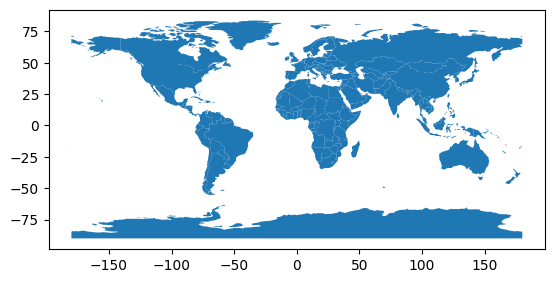

In [284]:
world.plot()

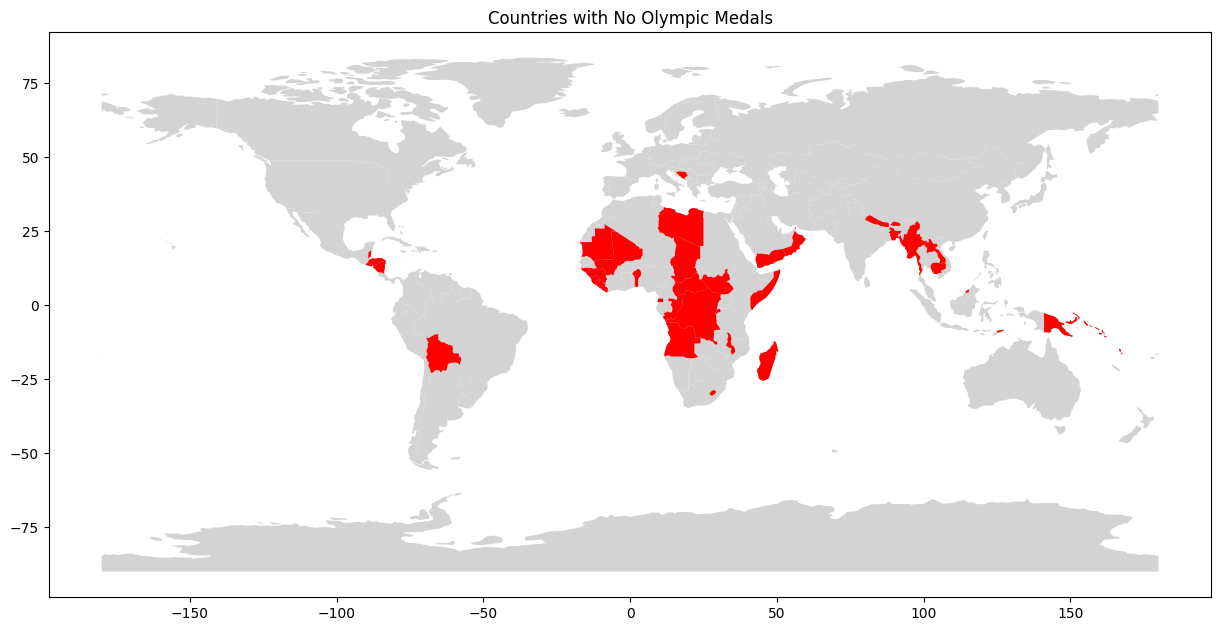

In [285]:
# Filter countries with no medals
no_medals_df = world[world['SOVEREIGNT'].isin(country_names)]

# Plot the map
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.plot(ax=ax, color='lightgrey')
no_medals_df.plot(ax=ax, color='red')

plt.title('Countries with No Olympic Medals')
plt.show()

In [288]:
world

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,TLC,ADMIN,...,FCLASS_TR,FCLASS_ID,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,geometry
0,Admin-0 country,1,6,Fiji,FJI,0,2,Sovereign country,1,Fiji,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((180 -16.06713, 180 -16.55522, ..."
1,Admin-0 country,1,3,United Republic of Tanzania,TZA,0,2,Sovereign country,1,United Republic of Tanzania,...,None,None,None,None,None,None,None,None,None,"POLYGON ((33.90371 -0.95, 34.07262 -1.05982, 3..."
2,Admin-0 country,1,7,Western Sahara,SAH,0,2,Indeterminate,1,Western Sahara,...,Unrecognized,Unrecognized,Unrecognized,None,None,Unrecognized,None,None,None,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,Admin-0 country,1,2,Canada,CAN,0,2,Sovereign country,1,Canada,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((-122.84 49, -122.97421 49.0025..."
4,Admin-0 country,1,2,United States of America,US1,1,2,Country,1,United States of America,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((-122.84 49, -120 49, -117.0312..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,Admin-0 country,1,5,Republic of Serbia,SRB,0,2,Sovereign country,1,Republic of Serbia,...,None,None,None,None,None,None,None,None,None,"POLYGON ((18.82982 45.90887, 18.82984 45.90888..."
173,Admin-0 country,1,6,Montenegro,MNE,0,2,Sovereign country,1,Montenegro,...,None,None,None,None,None,None,None,None,None,"POLYGON ((20.0707 42.58863, 19.80161 42.50009,..."
174,Admin-0 country,1,6,Kosovo,KOS,0,2,Disputed,1,Kosovo,...,Admin-0 country,Unrecognized,Admin-0 country,Unrecognized,Admin-0 country,Admin-0 country,Admin-0 country,Admin-0 country,Unrecognized,"POLYGON ((20.59025 41.85541, 20.52295 42.21787..."
175,Admin-0 country,1,5,Trinidad and Tobago,TTO,0,2,Sovereign country,1,Trinidad and Tobago,...,None,None,None,None,None,None,None,None,None,"POLYGON ((-61.68 10.76, -61.105 10.89, -60.895..."
